In [4]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
     

from fastcore.test import test_close

import logging
logging.disable(logging.WARNING)

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
set_seed(42)
mpl.rcParams['image.cmap'] = 'gray'

In [26]:
xl, yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean, xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [10]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
metrics = MetricsCB(MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [22]:
def conv(ni, nf, stride=2, ks=3, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, ks, stride,padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)


In [23]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers  = [conv(1,8, stride=2, ks=3, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=False, norm=norm, bias=True), nn.Flatten()).to(def_device)

In [28]:
set_seed(42)
lr = 6e-2
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act=GeneralRelu, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

MulticlassAccuracy,loss,epoch,train
0.789,0.739,0,train
0.826,0.517,0,eval
0.876,0.353,1,train
0.859,0.429,1,eval
0.897,0.286,2,train
0.893,0.302,2,eval
0.914,0.239,3,train
0.901,0.277,3,eval
0.930,0.197,4,train
0.910,0.254,4,eval


/home/metao/fastai2023/part2/.conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


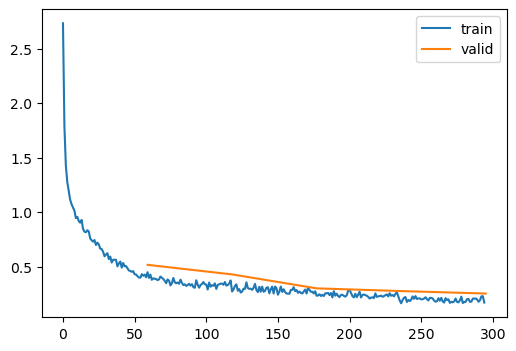

In [29]:
learn.fit(epochs)

In [30]:
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1,act=act ,norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None,norm=norm, ks=ks))

In [32]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noops if ni==nf else conv(ni,nf,ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

In [33]:
def get_model(act=nn.ReLU, nfs=(8,16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 8, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)
     

In [39]:
def _print_shape(hook, mod, inp, outp): print(type(mod).__name__, inp[0].shape, outp.shape)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, cbs=[DeviceCB(), SingleBatchCB()])
with Hooks(model, _print_shape) as hooks: learn.fit(1,train=False)

ResBlock torch.Size([2048, 1, 28, 28]) torch.Size([2048, 8, 28, 28])
ResBlock torch.Size([2048, 8, 28, 28]) torch.Size([2048, 16, 14, 14])
ResBlock torch.Size([2048, 16, 14, 14]) torch.Size([2048, 32, 7, 7])
ResBlock torch.Size([2048, 32, 7, 7]) torch.Size([2048, 64, 4, 4])
ResBlock torch.Size([2048, 64, 4, 4]) torch.Size([2048, 128, 2, 2])
ResBlock torch.Size([2048, 128, 2, 2]) torch.Size([2048, 256, 1, 1])
Flatten torch.Size([2048, 256, 1, 1]) torch.Size([2048, 256])
Linear torch.Size([2048, 256]) torch.Size([2048, 10])
BatchNorm1d torch.Size([2048, 10]) torch.Size([2048, 10])
